# Stima infetti reali

Stima infetti reali con backcasting.

> Max Pierini

***

Si presenta una stima degli infetti reali in Italia con metodo backcasting [Phipps et al. 2020](https://doi.org/10.1098/rsos.200909) basato su

- decessi osservati
- Infection Fatality Rate (IFR)
- periodo di incubazione
- periodo onset-to-death (dai sintomi al decesso)

Il backend per la stima degli infetti reali è stato tradotto in `Python` dall'originale in linguaggio `IDL` (vedi [Robust estimates of the true (population) infection rate for COVID-19: a backcasting approach](https://zenodo.org/record/4277651)).

I dati dei decessi e dei casi osservati dal repository GitHub COVID-19 del [Dipartimento di Protezione Civile](https://github.com/pcm-dpc/COVID-19).

L'IFR stimato per l'Italia è tratto da Imperial College Report 34 [Brazeau, Verity et al. 2020](https://www.imperial.ac.uk/mrc-global-infectious-disease-analysis/covid-19/report-34-IFR/) (tabella pag 9).

La stima backcasting degli ultimi 14 giorni circa non è attendibile, viene pertanto omessa dai grafici.

> NB: per questioni temporali la stima è effettuata con 250 simulazioni Monte Carlo anziché 10'000 come nel lavoro di Phipps et al.

In [1]:
import datetime as dt

import numpy as np
import pandas as pd
import scipy.stats as sps
import scipy.special as spsp
import scipy.optimize as opt
from sklearn.metrics import median_absolute_error

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
import seaborn as sns
sns.set()

from tqdm.notebook import tqdm

from IPython.display import display, Markdown, Latex

In [2]:
def overall_infectivity(incid, SI_y):
    T = incid.size
    _lambda = np.zeros(T)
    _lambda[0] = np.nan
    for t in range(T):
        if not t:
            continue
        _lambda[t] = np.sum(
            SI_y[:t+1] * 
            incid[:t+1][::-1]
        )
    return _lambda

def posterior_from_si_distr(incid, SI_y, a_prior, b_prior, t_start, t_end, ignore_under=50):
    nb_time_periods = t_start.size
    _lambda = overall_infectivity(incid, SI_y)
    final_mean_si = np.sum(
        SI_y * np.arange(0, SI_y.size, 1)
    )
    a_posterior = np.zeros(shape=nb_time_periods)
    b_posterior = np.zeros(shape=nb_time_periods)
    
    for t in range(nb_time_periods):
        incid_sum = np.sum(incid[t_start[t]:t_end[t]+1])
        if incid_sum > ignore_under and t_end[t] > final_mean_si:
            a_posterior[t] = a_prior + incid_sum
            b_posterior[t] = 1 / (1 / b_prior + np.sum(_lambda[t_start[t]:t_end[t]+1]))
        else:
            a_posterior[t] = 0.1
            b_posterior[t] = 1.0
    return a_posterior, b_posterior

def epi_estim_Rt(df,
                 SI_mu=None, SI_sd=None,
                 SI_sh=None, SI_ra=None,
                 mu_prior=5, sd_prior=5,
                 CI=.99,
                 plot_incidence=False,
                 plot_Rt=False,
                 plot_SI=False,
                 figsize=(12, 4),
                 ylim=(0, 4),
                 limit=None,
                 ignore_under=50,
                 plot_infectivity=False,
                 title='RESULTS',
                 window=14):
    
    cond1 = SI_mu is None and SI_sd is None
    cond2 = SI_sh is None and SI_ra is None
    
    if cond1 and cond2:
        raise Exception('Either SI_mu, SI_sd or SI_sh, SI_ra must be provided.')
    
    df = df.copy(deep=True)
    
    df.columns = ['incidence']
    incid = df.values.ravel()
    idx = df.index
    
    if plot_incidence:
        ax = df.plot(lw=1, color='k', alpha=.75, figsize=(12, 4))
        zero_incidence = df[df==0]
        if zero_incidence.size:
            ax.plot(zero_incidence, marker='o', ls='none', color='b', label='zero new cases')
        less_incidence = df[df<0]
        if less_incidence.size:
            ax.plot(less_incidence, marker='s', ls='none', color='r',label='less than zero')
        ax.legend()
        ax.set(
            title=f'{title} observed incidence'
        )
        plt.show()
    
    less_than_zero = incid < 0
    if less_than_zero.sum():
        #print('WARNING: negative values in incidence. Forcing to NaN. Values will be imputed.')
        df.loc[df.incidence<0, 'incidence'] = np.nan
    
    nans = np.isnan(incid).sum()
    if nans:
        #print('WARNING: NaN values in incidence. Imputing values with ffill method...')
        df.fillna(method='ffill', inplace=True)
        incid = df.values.ravel()
    
    # quantiles for confidence window
    q1 = (1 - .99) / 2
    q2 = 1 - q1
    
    if SI_mu is None:
        SI_mu, SI_sd = gamma_mu_sd_from_shape_rate(SI_sh, SI_ra)
    
    # calculate discretized serial window distribution
    SI_dist = sps.gamma(a=SI_sh, scale=1/SI_ra)
    SI_x_min = 0
    SI_x_max = int(SI_dist.ppf(.999))
    #SI_x = np.linspace(SI_x_min, SI_x_max, SI_x_max+1)
    SI_x = np.arange(0, incid.size, 1)
    SI_y = SI_dist.pdf(SI_x)
    SI_tot = SI_y / SI_y.sum()
    #SI_tot = SI_y[1:]
    # pad SI with zeros
    #SI_tot = np.concatenate((SI_y, np.zeros(incid.size - SI_y.size)))
    
    if plot_SI:
        fig, ax = plt.subplots(figsize=(12, 4))
        ax.bar(SI_x, SI_y, alpha=.5)
        ax.axvline(SI_mu, color='r', ls='--')
        ax.set(
            title=f'{title} Serial Interval: $\mu={SI_mu:.1f}$, $\sigma={SI_sd:.1f}$, '+\
                  f'shape={SI_sh:.3f}, rate={SI_ra:.3f}'
        )
        plt.show()
    
    # calculate shape and scale Rt priors
    a_prior = (mu_prior / sd_prior) ** 2    # shape
    b_prior = (sd_prior ** 2) / mu_prior    # scale
    
    # length of all observations
    T = incid.size
    
    # start and end of posteriors
    t_start = np.arange(1, T - (window - 1), 1)
    t_end = t_start + (window - 1)
    
    # calculate a and b posteriors
    a_posterior, b_posterior = posterior_from_si_distr(
        incid, SI_tot, a_prior, b_prior, t_start, t_end,
        ignore_under=ignore_under)

    # mean of Rt posteriors
    mean_posterior = a_posterior * b_posterior

    # standard deviation of Rt posteriors
    std_posterior = np.sqrt(a_posterior) * b_posterior

    # lower quantile of Rt posterior
    quantile_lo_posterior = sps.gamma.ppf(q1,
      a=a_posterior,
      scale=b_posterior
    )
    # higher quantile of Rt posterior
    quantile_hi_posterior = sps.gamma.ppf(q2,
      a=a_posterior,
      scale=b_posterior
    )
    
    #offset_idx = int(np.floor(window/2))
    res_index = idx[window:]
    res = pd.DataFrame({
        'date': res_index,
        'R': mean_posterior,
        'std': std_posterior,
        f'q_{q1:.2%}': quantile_lo_posterior,
        f'q_{q2:.2%}': quantile_hi_posterior,
    })
    res.set_index('date', inplace=True)
    
    if plot_Rt:
        fig, ax = plt.subplots(figsize=figsize)
        _ = res[:-limit].plot(y='R', ax=ax, color='k')
        ax.fill_between(
            res_index[:-limit],
            quantile_lo_posterior[:-limit], quantile_hi_posterior[:-limit],
            color='k', alpha=.2,
            label=f'CI {CI:.0%}'
        )
        ax.axhline(1, color='b', ls='--')
        if limit is not None:
            ax.axvline(res_index[-limit], color='r', ls='--', label='backcasting limit')
        #ylim = ax.get_ylim()
        ax.set(
            title=f'{title}: Rt estimation (EpiEstim method), window {window} days',
                  #f'SI  $\mu={SI_mu:.1f}$, $\sigma={SI_sd:.1f}$ days',
            ylim=ylim,
            xlim=(idx[0], idx[-1]),
            ylabel='Rt'
        )
        ax.tick_params(axis='y', which='both', labelleft='on', labelright='on')
        ax.legend(loc='lower left')
        plt.show()
    
    return res

In [3]:
ISS_sh = 1.87
ISS_ra = 0.28

def gamma_mu_sd_from_shape_rate(shape, rate):
    mu = shape / rate
    sd = np.sqrt(shape) / rate
    return mu, sd

def generation_time_gamma(sh, ra, plot=True, title='Estimated', size=None):

    dist = sps.gamma(a=sh, scale=1/ra)

    if size == None:
        max_x = int(np.ceil(dist.ppf(.9999)))
    else:
        max_x = size
    x = np.linspace(0, max_x, max_x+1)
    y = dist.pdf(x)
    y /= y.sum()
    
    mu, sd = gamma_mu_sd_from_shape_rate(sh, ra)
    
    if plot:
        fig, ax = plt.subplots(figsize=(12, 4))
        ax.bar(x, y, alpha=.5)
        ax.plot(x, y)
        ax.axvline(mu, color='r', ls='--', label=f'mean {mu:.1f} days')
        ax.legend()
        ax.set(
            title=f'{title} COVID-19 Generation Interval '+\
                  f'shape={sh:.3f}, rate={ra:.3f}',
            xlabel='days',
            ylabel='probability density'
        )
        plt.show()

    return x, y, mu, sd

In [4]:
dt_start = dt.datetime.now()

In [5]:
df = pd.read_csv(
    "https://github.com/pcm-dpc/COVID-19/raw/master/dati-andamento-nazionale/"
    "dpc-covid19-ita-andamento-nazionale.csv",
    parse_dates=['data'], index_col='data'
)
df.index = df.index.normalize()

In [6]:
_ = """jh_c = pd.read_csv(
    'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
)
jh_d = pd.read_csv(
    'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
)

jh_c_it = jh_c[jh_c['Country/Region']=='Italy'].iloc[:,4:].T
jh_d_it = jh_d[jh_d['Country/Region']=='Italy'].iloc[:,4:].T

jh_d_it.columns = ['deceduti']
jh_c_it.columns = ['totale_casi']

jh_d_it.index = pd.to_datetime(jh_d_it.index)
jh_c_it.index = pd.to_datetime(jh_c_it.index)

jh_it = jh_d_it.merge(
    jh_c_it,
    left_index=True, right_index=True
)

iss = pd.read_excel(
    'https://www.epicentro.iss.it/coronavirus/open-data/covid_19-iss.xlsx',
    sheet_name=['decessi', 'casi_prelievo_diagnosi']
)

iss['decessi']['date'] = pd.to_datetime(
    iss['decessi'].DATA_DECESSO, format='%d/%m/%Y'
)

iss['casi_prelievo_diagnosi']['date'] = pd.to_datetime(
    iss['casi_prelievo_diagnosi'].DATA_PRELIEVO_DIAGNOSI, format='%d/%m/%Y'
)

iss['decessi'].loc[iss['decessi'].DECESSI=='<5', 'DECESSI'] = 0
iss['decessi']['DECESSI'] = iss['decessi'].DECESSI.astype(int)
iss['decessi'].dropna(inplace=True)
iss['decessi'].set_index('date', inplace=True)

iss['casi_prelievo_diagnosi'].loc[iss['casi_prelievo_diagnosi'].CASI=='<5', 'CASI'] = 0
iss['casi_prelievo_diagnosi']['CASI'] = iss['casi_prelievo_diagnosi'].CASI.astype(int)
iss['casi_prelievo_diagnosi'].dropna(inplace=True)
iss['casi_prelievo_diagnosi'].set_index('date', inplace=True)

prev_dt_range_D = pd.date_range(
    '2020-01-01',
    iss['decessi'].index[0]
)
prev_iss_D = pd.DataFrame(columns=iss['decessi'].columns, index=prev_dt_range_D)

prev_dt_range_C = pd.date_range(
    '2020-01-01',
    iss['casi_prelievo_diagnosi'].index[0]
)
prev_iss_C = pd.DataFrame(columns=iss['casi_prelievo_diagnosi'].columns, index=prev_dt_range_C)

prev_iss_D['DECESSI'] = 0
prev_iss_C['CASI'] = 0

iss_D = prev_iss_D.append(iss['decessi'])
iss_C = prev_iss_C.append(iss['casi_prelievo_diagnosi'])

ISS = iss_D[['DECESSI']].merge(
    iss_C[['CASI']],
    left_index=True, right_index=True
)

ISS['DECESSI_TOTALI'] = ISS['DECESSI'].cumsum()
ISS['CASI_TOTALI'] = ISS['CASI'].cumsum()"""

In [7]:
prev_dt_range = pd.date_range(
    pd.to_datetime('2020-01-01'),
    df.index[0] - pd.Timedelta(days=1)
)
prev_DPC = pd.DataFrame(columns=df.columns, index=prev_dt_range)

In [8]:
prev_DPC.loc[:,:] = 0

In [9]:
DF = prev_DPC.append(df)

In [10]:
DF['nuovi_deceduti'] = DF.deceduti.diff()

In [11]:
DF.fillna(0, inplace=True)

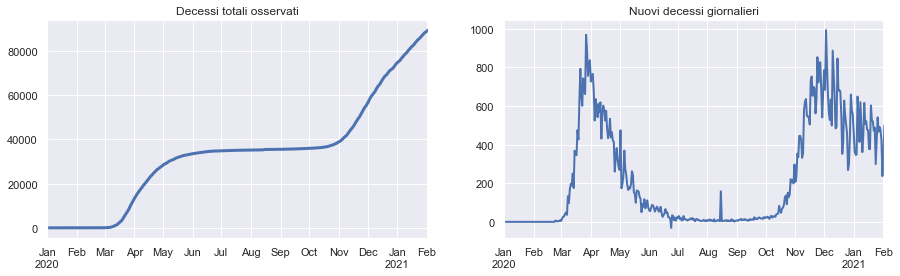

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
DF.plot(y='deceduti', ax=ax[0], title='Decessi totali osservati', legend=None, lw=3)
DF.plot(y='nuovi_deceduti', ax=ax[1], title='Nuovi decessi giornalieri', legend=None, lw=2)
plt.show()

In [13]:
# Read data
n_cas = DF.totale_casi.values.ravel()
n_fat = DF.deceduti.values.ravel()
n_dfat = DF.nuovi_deceduti.values.ravel()
# fix errors
n_dfat[n_dfat<0] = 0
assert n_cas.size == n_dfat.size

In [14]:
# Define independent parameters
day0 = 0  # 02 February 2020
n_days = n_dfat.size
n_monte = 250  # 10000
cov1 = 0.86
cov2 = 0.45
dt_incubation_min = 4.1
dt_incubation_max = 7.0
dt_onset_min = 12.8
dt_onset_max = 19.2
ifr_min = 2.03 / 100  # 0.78 / 100  # 0.0037
ifr_max = 2.45 / 100  # 1.79 / 100  # 0.0115
missing_value = -1.0e34

In [15]:
# Declare variables
#det_rate_02p5 = np.ndarray(n_days)
#det_rate_05p0 = np.ndarray(n_days)
#det_rate_95p0 = np.ndarray(n_days)
#det_rate_97p5 = np.ndarray(n_days)
det_rate_median = np.ndarray(n_days)
det_rate_monte = np.ndarray((n_days, n_monte))
dn_inf = np.ndarray(n_days)
#n_cas = np.ndarray(n_days)
#n_dfat = np.ndarray(n_days)
#n_fat = np.ndarray(n_days)
#n_inf_02p5 = np.ndarray(n_days)
#n_inf_05p0 = np.ndarray(n_days)
#n_inf_95p0 = np.ndarray(n_days)
#n_inf_97p5 = np.ndarray(n_days)
n_inf_median = np.ndarray(n_days)
n_inf_monte = np.ndarray((n_days, n_monte))

In [16]:
# Initialise variables
#det_rate_02p5[:] = missing_value
#det_rate_05p0[:] = missing_value
#det_rate_95p0[:] = missing_value
#det_rate_97p5[:] = missing_value
det_rate_median[:] = missing_value
det_rate_monte[:,:] = missing_value
dn_inf[:] = missing_value
#n_cas[:] = missing_value
#n_dfat[:] = missing_value
#n_fat[:] = missing_value
#n_inf_02p5[:] = missing_value
#n_inf_05p0[:] = missing_value
#n_inf_95p0[:] = missing_value
#n_inf_97p5[:] = missing_value
n_inf_median[:] = missing_value
n_inf_monte[:,:] = missing_value

In [17]:
# Derive the implied means and standard deviations of the parameter
# distributions, assuming that the specified uncertainty ranges for each
# paramter represent the 95% confidence intervals of a normal distribution
ifr_mean = 0.5 * (ifr_min + ifr_max)
dt_incubation_mean = 0.5 * (dt_incubation_min + dt_incubation_max)
dt_onset_mean = 0.5 * (dt_onset_min + dt_onset_max)

In [18]:
ifr_sd = (ifr_max - ifr_min) / (sps.norm.isf(.025) - sps.norm.isf(.975))
dt_incubation_sd = (dt_incubation_max - dt_incubation_min) / (sps.norm.isf(.025) - sps.norm.isf(.975))
dt_onset_sd = (dt_onset_max - dt_onset_min) / (sps.norm.isf(.025) - sps.norm.isf(.975))

Distribuzioni dei parametri:

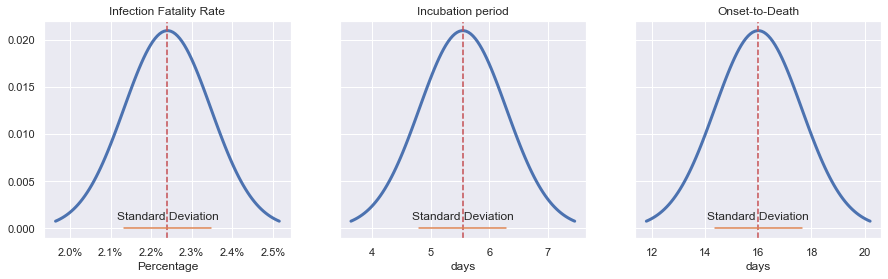

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

ifr_dist = sps.norm(loc=ifr_mean, scale=ifr_sd)
ifr_X = np.linspace(ifr_dist.ppf(.005), ifr_dist.ppf(1-.005), 100)
ifr_Y = ifr_dist.pdf(ifr_X)
ifr_Y /= ifr_Y.sum()
ax[0].plot(ifr_X, ifr_Y, lw=3)
ax[0].axvline(ifr_mean, ls='--', color='r')
ax[0].plot([ifr_mean-ifr_sd, ifr_mean+ifr_sd], [0,0])
ax[0].text(
    .5, .075,
    'Standard Deviation',
    ha='center', va='bottom',
    transform=ax[0].transAxes
)
ax[0].set_title('Infection Fatality Rate')
ax[0].xaxis.set_major_formatter(mtick.PercentFormatter(1, 1))
ax[0].set(
    xlabel='Percentage'
)

dt_incubation_dist = sps.norm(loc=dt_incubation_mean, scale=dt_incubation_sd)
dt_incubation_X = np.linspace(dt_incubation_dist.ppf(.005), dt_incubation_dist.ppf(1-.005), 100)
dt_incubation_Y = dt_incubation_dist.pdf(dt_incubation_X)
dt_incubation_Y /= dt_incubation_Y.sum()
ax[1].plot(dt_incubation_X, dt_incubation_Y, lw=3)
ax[1].axvline(dt_incubation_mean, ls='--', color='r')
ax[1].plot([dt_incubation_mean-dt_incubation_sd, dt_incubation_mean+dt_incubation_sd], [0,0])
ax[1].text(
    .5, .075,
    'Standard Deviation',
    ha='center', va='bottom',
    transform=ax[1].transAxes
)
ax[1].set_title('Incubation period')
ax[1].set(
    xlabel='days'
)

dt_onset_dist = sps.norm(loc=dt_onset_mean, scale=dt_onset_sd)
dt_onset_X = np.linspace(dt_onset_dist.ppf(.005), dt_onset_dist.ppf(1-.005), 100)
dt_onset_Y = dt_onset_dist.pdf(dt_onset_X)
dt_onset_Y /= dt_onset_Y.sum()
ax[2].plot(dt_onset_X, dt_onset_Y, lw=3)
ax[2].axvline(dt_onset_mean, ls='--', color='r')
ax[2].plot([dt_onset_mean-dt_onset_sd, dt_onset_mean+dt_onset_sd], [0,0])
ax[2].text(
    .5, .075,
    'Standard Deviation',
    ha='center', va='bottom',
    transform=ax[2].transAxes
)
ax[2].set_title('Onset-to-Death')
ax[2].set(
    xlabel='days'
)

plt.show()

In [20]:
# Derive the estimated cumulative number of infections, using a Monte Carlo
# method to sample parameter uncertainty
for monte in tqdm(range(n_monte)):
    
  # Derive a random value for ifr
    x1 = sps.norm.rvs(loc=0, scale=1, size=1)
    while (abs(x1) > sps.norm.isf(.025)):
        x1 = sps.norm.rvs(loc=0, scale=1, size=1)
    ifr = ifr_mean + x1 * ifr_sd
    
    # Derive a random value for dt_incubation
    x2 = sps.norm.rvs(loc=0, scale=1, size=1)
    while (abs(x2) > sps.norm.isf(.025)):
        x2 = sps.norm.rvs(loc=0, scale=1, size=1)
    dt_incubation = dt_incubation_mean + x2 * dt_incubation_sd
    
    # Derive a random value for dt_onset
    x3 = sps.norm.rvs(loc=0, scale=1, size=1)
    while (abs(x3) > sps.norm.isf(.025)):
        x3 = sps.norm.rvs(loc=0, scale=1, size=1)
    dt_onset = dt_onset_mean + x3 * dt_onset_sd
    
    # Derive the parameters for the Gamma distribution
    dt_death = dt_incubation + dt_onset
    sd1 = cov1 * dt_incubation
    sd2 = cov2 * dt_onset
    sd = np.sqrt(sd1**2 + sd2**2)
    cov = sd / dt_death
    alpha = 1.0 / cov**2
    beta = dt_death * cov**2
    denominator = beta**alpha * spsp.gamma(alpha)
    
    # Derive the estimated cumulative number of infections
    #
    # Reset the array containing daily new infections
    dn_inf[:] = 0.0

    # Loop over each day to apportion fatalities
    for i_fat in range(n_days)[::-1][:-1]:

        # Loop over each preceding day to receive fatalities
        for i_inf in range(i_fat)[::-1]:

            # Calculate the value of the Gamma function
            x = float(i_fat - i_inf)
            pdf = (x**(alpha-1.0) * np.exp(0.0-x/beta)) / denominator

            # Estimate the number of new infections
            dn_inf[i_inf] = dn_inf[i_inf] + (pdf * n_dfat[i_fat]) / ifr
            
    # Scale the number of new infections to allow for the fraction of fatalities
    # that have not occurred yet
    for i in range(n_days-1):
        x = float(n_days - 1 - i)
        cdf = spsp.gammainc(alpha, x/beta)
        dn_inf[i] = dn_inf[i] / cdf

    # Calculate the cumulative number of new infections
    n_inf_monte[0, monte] = dn_inf[0]
    for i in range(n_days)[1:]:
        n_inf_monte[i, monte] = n_inf_monte[i-1, monte] + dn_inf[i]

    # Derive the implied detection rates
    for i in range(n_days-1):
        if (n_inf_monte[i, monte] > 0.5):
            det_rate_monte[i, monte] = n_cas[i] / n_inf_monte[i, monte]

In [21]:
#; Remove any incomplete Monte Carlo samples for the implied detection rates
for i in range(n_days):
    if (min(det_rate_monte[i, :]) < -1.0e30):
        det_rate_monte[i, :] = np.nan

# Risultati

In [22]:
n_inf_median = np.median(n_inf_monte, axis=1)

In [23]:
# 95% CI
n_inf_lo, n_inf_hi = np.percentile(n_inf_monte, [2.5, 97.5], axis=1)
# 50% CI
#n_inf_25, n_inf_75 = np.percentile(n_inf_monte, [25, 75], axis=1)

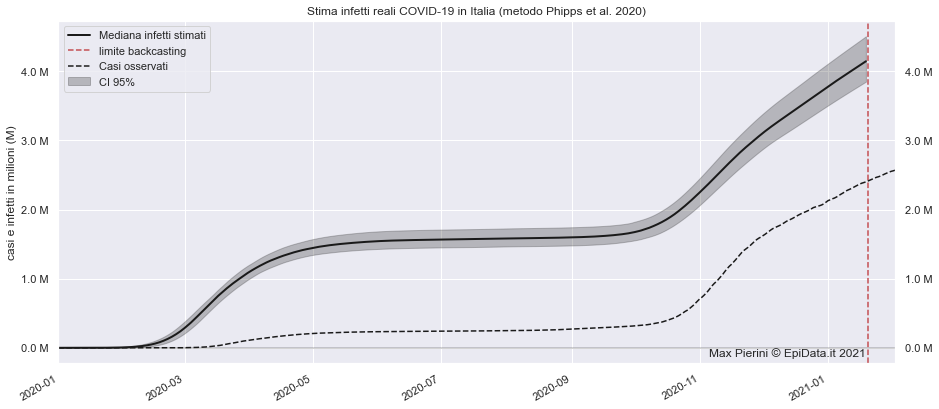

In [24]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(DF.index[:-14], n_inf_median[:-14], color='k', lw=2, label='Mediana infetti stimati')
ax.fill_between(
    DF.index[:-14],
    n_inf_lo[:-14], n_inf_hi[:-14],
    alpha=.25, color='k',
    label='CI 95%'
)
ax.axvline(DF.index[-14], color='r', ls='--', label='limite backcasting')
DF.totale_casi.plot(label='Casi osservati', ls='--', color='k', ax=ax)
ax.ticklabel_format(axis='y', style='plain')
ylim = ax.get_ylim()
ax.set(
    yticks=ax.get_yticks(),
    yticklabels=[f"{i:.1f} M" for i in ax.get_yticks()/1e6],
)
ax.set(
    xlim=(DF.index[0], DF.index[-1]),
    ylim=ylim,
    title='Stima infetti reali COVID-19 in Italia (metodo Phipps et al. 2020)',
    ylabel='casi e infetti in milioni (M)'
)
ax.tick_params(axis='y', which='both', labelleft=True, labelright=True)
ax.axhline(0, color='k', alpha=.25)
ax.legend(loc='upper left')
ax.text(
    DF.index[-15], 0,
    'Max Pierini © EpiData.it 2021',
    ha='right', va='top'
)
plt.show()

In [25]:
n_dinf_median = np.median(np.diff(n_inf_monte, axis=0), axis=1)

n_dinf_lo, n_dinf_hi = np.percentile(
    np.diff(n_inf_monte, axis=0), 
    [2.5, 97.5], axis=1
)
#n_dinf_25, n_dinf_75 = np.percentile(
#    np.diff(n_inf_monte, axis=0), 
#    [25, 75], axis=1
#)

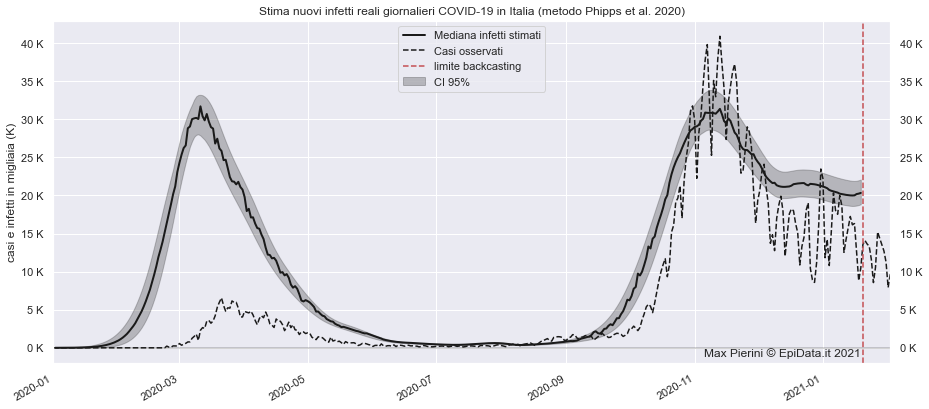

In [26]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(DF.index[1:-14], np.diff(n_inf_median)[:-14], color='k', lw=2, label='Mediana infetti stimati')
ax.fill_between(
    DF.index[1:-14],
    n_dinf_lo[:-14], n_dinf_hi[:-14],
    alpha=.25, color='k',
    label='CI 95%'
)
DF.nuovi_positivi.plot(label='Casi osservati', ls='--', color='k', ax=ax)
ax.axvline(DF.index[-14], color='r', ls='--', label='limite backcasting')
ax.ticklabel_format(axis='y', style='plain')
ylim=ax.get_ylim()
ax.set(
    yticks=ax.get_yticks(),
    yticklabels=[f"{i:.0f} K" for i in ax.get_yticks()/1e3],
)
ax.set(
    xlim=(DF.index[0], DF.index[-1]),
    ylim=ylim,
    title='Stima nuovi infetti reali giornalieri COVID-19 in Italia (metodo Phipps et al. 2020)',
    ylabel='casi e infetti in migliaia (K)'
)
ax.tick_params(axis='y', which='both', labelleft=True, labelright=True)
ax.axhline(0, color='k', alpha=.25)
ax.legend(loc='upper center')
ax.text(
    DF.index[-15], 0,
    'Max Pierini © EpiData.it 2021',
    ha='right', va='top'
)
plt.show()

In [27]:
det_rate_median = np.median(det_rate_monte, axis=1)

In [28]:
# 95% CI
det_rate_lo, det_rate_hi = np.percentile(det_rate_monte, [2.5, 97.5], axis=1)
# 50% CI
#det_rate_25, det_rate_75 = np.percentile(det_rate_monte, [25, 75], axis=1)

In [29]:
n_cas_rolling = pd.Series(n_cas).diff().rolling(7, center=True).mean().values.ravel()[1:]

In [30]:
old_settings = np.seterr(all='ignore')

det_drate_median = n_cas_rolling / n_dinf_median

det_drate_median[det_drate_median>1] = 1
det_drate_median[det_drate_median<0] = 0

#det_drate_median_rolling = pd.Series(det_drate_median).rolling(7, center=True).mean()

det_drate_lo = n_cas_rolling / n_dinf_lo
det_drate_hi = n_cas_rolling / n_dinf_hi

det_drate_lo[det_drate_lo>1] = 1
det_drate_hi[det_drate_hi>1] = 1

det_drate_lo[det_drate_lo<0] = 0
det_drate_hi[det_drate_hi<0] = 0

#det_drate_lo_rolling = pd.Series(det_drate_lo).rolling(7, center=True).mean()
#det_drate_hi_rolling = pd.Series(det_drate_hi).rolling(7, center=True).mean()

_ = np.seterr(**old_settings)

# Tasso di rilevamento

Stima del tasso di rilevamento, ovvero quanti infetti mediamente vengono rilevati dai test positivi.

Il tasso di rilevamento giornaliero (a destra) indica mediamente quanti infetti vengono rilevati dai test positivi ogni giorno.

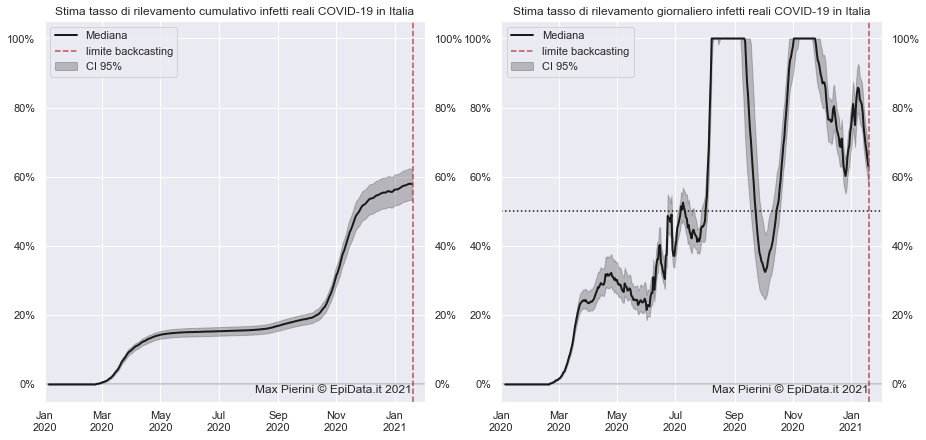

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7), sharex=True, sharey=True)
ax[0].plot(DF.index[:-14], det_rate_median[:-14], color='k', lw=2, label='Mediana')
ax[0].fill_between(
    DF.index[:-14],
    det_rate_lo[:-14], det_rate_hi[:-14],
    alpha=.25, color='k',
    label='CI 95%'
)
ax[0].axvline(DF.index[-14], color='r', ls='--', label='limite backcasting')
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(1, 0))
ax[0].tick_params(axis='y', which='both', labelleft=True, labelright=True)
ax[0].set(
    xlim=(DF.index[0], DF.index[-1]),
    title='Stima tasso di rilevamento cumulativo infetti reali COVID-19 in Italia'
)
ax[0].legend(loc='upper left')
ax[0].text(
    DF.index[-15], 0,
    'Max Pierini © EpiData.it 2021',
    ha='right', va='top'
)
ax[0].axhline(0, color='k', alpha=.25)
ax[0].xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%b\n%Y"))

#ax[1].plot(jh_it.index[1:-2], det_drate_median, color='r', ls='none', marker='.', alpha=.5)
ax[1].plot(DF.index[1:-14], det_drate_median[:-14], color='k', lw=2, label='Mediana')
ax[1].fill_between(
    DF.index[1:-14],
    det_drate_lo[:-14], det_drate_hi[:-14],
    alpha=.25, color='k',
    label='CI 95%'
)
ax[1].axvline(DF.index[-14], color='r', ls='--', label='limite backcasting')
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter(1, 0))
ax[1].tick_params(axis='y', which='both', labelleft=True, labelright=True)
ax[1].set(
    xlim=(DF.index[0], DF.index[-1]),
    title='Stima tasso di rilevamento giornaliero infetti reali COVID-19 in Italia'
)
ax[1].legend(loc='upper left')
ax[1].text(
    DF.index[-15], 0,
    'Max Pierini © EpiData.it 2021',
    ha='right', va='top'
)
ax[1].axhline(0, color='k', alpha=.25)
ax[1].axhline(.5, color='k', ls=':',)
ax[1].xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax[1].xaxis.set_major_formatter(mdates.DateFormatter("%b\n%Y"))

plt.show()

# Numero di riproduzione

Numero di riproduzione effettivo nel tempo $R_t$ stimato con metodo `EpiEstim` a partite dagli infetti reali stimati con metodo Phipps et al.

In [32]:
Rdf = pd.DataFrame({'nuovi_positivi': np.diff(n_inf_median).astype(int)}, index=DF.index[1:])

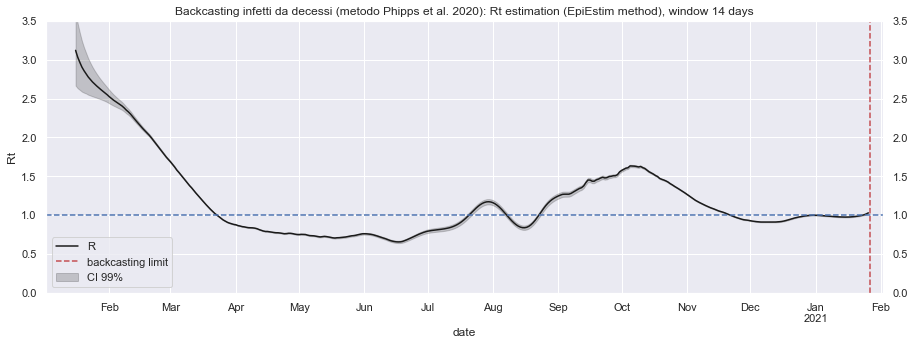

In [35]:
Rt = epi_estim_Rt(
    Rdf.nuovi_positivi,
    SI_sh=ISS_sh, 
    SI_ra=ISS_ra, 
    window=14, 
    plot_Rt=True, figsize=(15, 5),
    ylim=(0, 3.5),
    limit=7,
    title='Backcasting infetti da decessi (metodo Phipps et al. 2020)'
)

In [34]:
dt_end = dt.datetime.now()
dt_time = dt_end - dt_start
print("Computed in", dt_time)

Computed in 0:04:46.841950
